In [2]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langgraph.types import Send
from langchain_openai import ChatOpenAI

@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"


raw_model = ChatOpenAI()
model = raw_model.with_structured_output(get_weather)

class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state["messages"])
    return {"city": result["city"]}


def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state["city"]})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])
# subgraph = subgraph.compile()

In [3]:
import time
    
@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"


raw_model = ChatOpenAI()
model = raw_model.with_structured_output(get_weather)

class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model.invoke(state["messages"])
    # time.sleep(5)
    return {"city": result["city"]}


def weather_node1(state: SubGraphState):
    result = get_weather.invoke({"city": state["city"]})
    # time.sleep(5)
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph2 = StateGraph(SubGraphState)
subgraph2.add_node(model_node)
subgraph2.add_node(weather_node1)
subgraph2.add_edge(START, "model_node")
subgraph2.add_edge("model_node", "weather_node1")
subgraph2.add_edge("weather_node1", END)
# subgraph2 = subgraph2.compile()
subgraph2 = subgraph2.compile(interrupt_after=["weather_node1"])

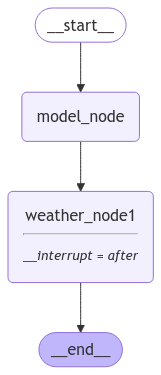

In [4]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(subgraph2.get_graph(xray=1).draw_mermaid_png()))

In [5]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

# Initialize memory saver to track the state of the graph
memory = MemorySaver()

class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]

# Define the model for structured output of the router
router_model = raw_model.with_structured_output(Router)

# Router node which decides the route
def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    print(f"Router Node: Incoming messages: {messages}")  # Debugging log
    route = router_model.invoke(messages)
    print(f"Router Node: Decided route: {route['route']}")  # Debugging log
    return {"route": route["route"]}

# Normal LLM node for non-weather queries
def normal_llm_node(state: RouterState):
    print(f"Normal LLM Node: Processing messages: {state['messages']}")  # Debugging log
    response = raw_model.invoke(state["messages"])
    print(f"Normal LLM Node: Response: {response}")  # Debugging log
    return {"messages": [response]}

# Conditional routing after the prediction from the router node
def route_after_prediction(state: RouterState) -> Literal["weather_graph", "weather_graph2"]:
    print(f"Route After Prediction: route is {state['route']}")  # Debugging log
    if state["route"] == "weather" or 1:
        send_list = [Send("weather_graph", {"messages": state["messages"]}) for _ in range(3)]
        print(f"Route After Prediction: Sending to weather_graph 3 times")  # Debugging log
        return send_list
    else:
        send_list = [Send("weather_graph2", {"messages": state["messages"]}),]
        print(f"Route After Prediction: Sending to weather_graph2")  # Debugging log
        return send_list

# Define the state graph
graph = StateGraph(RouterState)

# Add nodes to the graph
graph.add_node(router_node)
# graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_node("weather_graph2", subgraph2)

# Define edges
graph.add_edge(START, "router_node")
graph.add_edge("router_node", "weather_graph2")
graph.add_conditional_edges("router_node", route_after_prediction)
# graph.add_edge("router_node", normal_llm_node)
# graph.add_edge("normal_llm_node", END)
# graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph.add_edge("weather_graph2", END)

# Compile the graph with checkpointing enabled
graph = graph.compile(checkpointer=memory)

# You can now test this graph


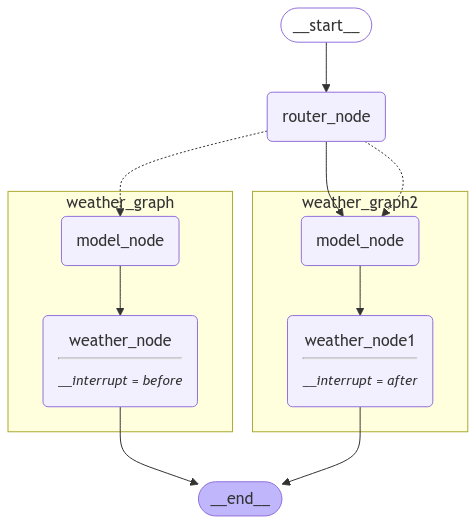

In [6]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

Router Node: Incoming messages: [{'role': 'system', 'content': 'Classify the incoming query as either about weather or not.'}, HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='2b5fc308-da41-4ff4-b153-77f25b7828d7')]
Router Node: Decided route: other
Route After Prediction: route is other
Route After Prediction: Sending to weather_graph 3 times
{'router_node': {'route': 'other'}}
{'__interrupt__': ()}


In [8]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

Router Node: Incoming messages: [{'role': 'system', 'content': 'Classify the incoming query as either about weather or not.'}, HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f3373d30-364d-4a11-a472-10b80f20249e')]
Router Node: Decided route: weather
Route After Prediction: route is weather
Route After Prediction: Sending to weather_graph 3 times
{'router_node': {'route': 'weather'}}
{'__interrupt__': ()}


In [9]:
state = graph.get_state(config, subgraphs=True)

In [35]:
graph.update_state(config, values={"route": "weather"})
graph

Route After Prediction: route is weather
Route After Prediction: Sending to weather_graph 3 times


In [38]:
state = graph.get_state(config, subgraphs=True)
state.tasks[0].state

StateSnapshot(values={}, next=(), config={'configurable': {'__pregel_checkpointer': <langgraph.checkpoint.memory.MemorySaver object at 0x7f8007211dd0>, 'thread_id': '2', 'checkpoint_ns': 'weather_graph:d6d22f8a-a9e4-cc39-5eed-e0a6fd44b366'}}, metadata=None, created_at=None, parent_config=None, tasks=())

In [ ]:
StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f3373d30-364d-4a11-a472-10b80f20249e')], 'route': 'weather'}, next=('weather_graph', 'weather_graph', 'weather_graph', 'weather_graph2'), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efae91d-78d6-663d-8006-02e8c57187ea'}}, metadata={'source': 'update', 'writes': {'router_node': {'route': 'weather'}}, 'thread_id': '2', 'step': 6, 'parents': {}}, created_at='2024-11-29T20:38:08.163353+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efae91c-809a-62a2-8005-b89743a9e3f8'}}, tasks=(PregelTask(id='d40410eb-a4a1-36d2-78de-1dfff1e01644', name='weather_graph', path=('__pregel_push', 0), error=None, interrupts=(), state=StateSnapshot(values={}, next=(), config={'configurable': {'__pregel_checkpointer': <langgraph.checkpoint.memory.MemorySaver object at 0x7f8007211dd0>, 'thread_id': '2', 'checkpoint_ns': 'weather_graph:d40410eb-a4a1-36d2-78de-1dfff1e01644'}}, metadata=None, created_at=None, parent_config=None, tasks=()), result=None), PregelTask(id='70a1acee-a2ad-2037-9a1f-ee6d1054caee', name='weather_graph', path=('__pregel_push', 1), error=None, interrupts=(), state=StateSnapshot(values={}, next=(), config={'configurable': {'__pregel_checkpointer': <langgraph.checkpoint.memory.MemorySaver object at 0x7f8007211dd0>, 'thread_id': '2', 'checkpoint_ns': 'weather_graph:70a1acee-a2ad-2037-9a1f-ee6d1054caee'}}, metadata=None, created_at=None, parent_config=None, tasks=()), result=None), PregelTask(id='bf09075d-ae2c-7e73-ab29-a153f4d3c523', name='weather_graph', path=('__pregel_push', 2), error=None, interrupts=(), state=StateSnapshot(values={}, next=(), config={'configurable': {'__pregel_checkpointer': <langgraph.checkpoint.memory.MemorySaver object at 0x7f8007211dd0>, 'thread_id': '2', 'checkpoint_ns': 'weather_graph:bf09075d-ae2c-7e73-ab29-a153f4d3c523'}}, metadata=None, created_at=None, parent_config=None, tasks=()), result=None), PregelTask(id='1c88fc4a-dd20-bd40-fec7-a64bd3295342', name='weather_graph2', path=('__pregel_pull', 'weather_graph2'), error=None, interrupts=(), state=StateSnapshot(values={}, next=(), config={'configurable': {'__pregel_checkpointer': <langgraph.checkpoint.memory.MemorySaver object at 0x7f8007211dd0>, 'thread_id': '2', 'checkpoint_ns': 'weather_graph2:1c88fc4a-dd20-bd40-fec7-a64bd3295342'}}, metadata=None, created_at=None, parent_config=None, tasks=()), result=None)))

{'__interrupt__': ()}


In [5]:
import openai
import base64
import os

client = openai.OpenAI( api_key=os.getenv("OPENAI_API_KEY"))
THIS_MODEL = "gpt-4o-mini"
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

image_path = "image.png"

# Getting the base64 string
base64_image = encode_image(image_path)

# Send the request to the API
response = client.chat.completions.create(
        model=THIS_MODEL,
        messages=[
            {
                "role": "system",
                "content": [
                    {"type": "text",
                    "text": "You are a image analyst.  Your goal is to describe what is in the image provided as a file to the greatest detail possible."
                    }
                ],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type":"text",
                        "text": "What is in this image?"
                    },
                    {
                        "type": "image_url",
                        "image_url": 
                            {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                    }
                ]
            }
        ],
        max_tokens=300
    )
print(f"response: {response}")
# Extract the description
description = response.choices[0].message.content
print(f"Desription: {description}")



response: ChatCompletion(id='chatcmpl-AZEefwhf8aaWjm4dr5YLByimvLRV6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image depicts two characters in an animated style, standing on a staircase. They are facing each other closely, almost touching foreheads, suggesting an intimate or emotional moment. \n\n- **Character Details**: \n  - The boy has short, tousled black hair and is wearing a dark suit with a white shirt and tie. He carries a backpack.\n  - The girl has long, dark hair and is dressed in a light pink top and pants, holding a brown bag.\n\n- **Setting**: The background features a sunlit outdoor area with greenery, including plants and a rock wall. The setting feels serene and might suggest a transitional moment in the story.\n\n- **Atmosphere**: The lighting gives a warm, vibrant feeling, enhancing the emotional tension between the two characters.\n\nOverall, the scene conveys a sense of connection and possibly a signif

In [25]:

print(image_to_description("image3.png"))

### Detailed description of the image in high detail

The image consists of three heatmap plots side by side, each titled with different model names: "GPT-4o", "Gemini-v1.5", and "LLaVA-v1.5-7B". The heatmaps plot "Needle Depth (%)" against the "Number of Images", with values indicating raw accuracy. The y-axis, labeled "Needle Depth (%)", ranges from 0-10% to 90-100%, and the x-axis represents the number of images, specifically 1, 2, 3, 5, 10, 20, 50, and 100. A color gradient from green to red indicates the raw accuracy scale from 1 to 0.5, with gray boxes on the "LLaVA-v1.5-7B" plot indicating missing data. Below the plots, a figure caption explains the context of the data, specifically referencing a benchmark (VHs) and discussing the impact of "needle position" on performance.

### Text in the image - Don't miss any text

- **GPT-4o**
- **Gemini-v1.5**
- **LLaVA-v1.5-7B**
- **Needle Depth (%)**
- **Number of Images**
- **Raw Accuracy**
- Caption: "Figure 2: Plots showing needle pos

In [23]:
def image_to_description(image_path):

    client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    THIS_MODEL = "gpt-4o"
    # Function to encode the image
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')

    # image_path = "image.png"

    # Getting the base64 string
    base64_image = encode_image(image_path)

    # Send the request to the API
    response = client.chat.completions.create(
            model=THIS_MODEL,
            messages=[
                {
                    "role": "system",
                    "content": [
                        {"type": "text",
                        "text": """
                        You are a part of the financial assistant built by our team. Your goal is to describe what is in the image provided as a file to the greatest detail possible. If it contains any numbers or has informatics, ypu should include that in your description. If it has any text, please include that as well. No information is too small. Please provide a detailed description of the image.
                        You should include every little detail you can see in the image.
                        You need to keep in mind that every text and number in the image is important.
                        
                        Format your response as follows, give me formatted in markdown:
                        The below are the headings you should include in your response:
                        - Detailed description of the image in high detail
                        - Text in the image - Don't miss any text
                        - Numbers in the image - This is very important
                        - Analysis of the details in the image
                        
                        Strictly follow all the instructions given above.
                        """
                        }
                    ],
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type":"text",
                            "text": "Do your job on the image"
                            },
                        {
                            "type": "image_url",
                            "image_url": 
                                {
                                    "url": f"data:image/jpeg;base64,{base64_image}"
                                }
                        }
                    ]
                }
            ],
            max_tokens=3000
        )
    # print(f"response: {response}")
    # Extract the description
    description = response.choices[0].message.content
    # print(f"Desription: {description}")
    return description